In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np

In [8]:
train_losses = np.load('train_losses_v2_10_ffw.npy')
test_losses = np.load('test_losses_v2_10_ffw.npy')

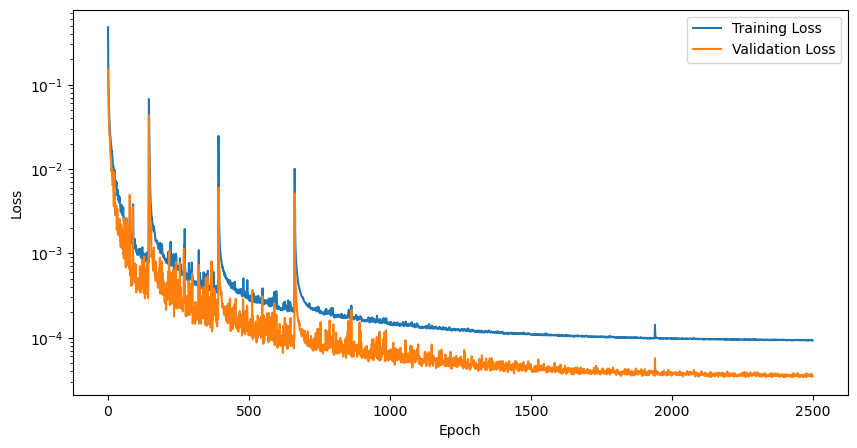

In [9]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [10]:
from train import *
import torch
predict_num = 10
train_dataset, test_dataset, n_features, n_inputs = data_preparation_v2(predict_num, 140)
params = Params(n_features, n_inputs)
model = build_model(params)
model = torch.load('model_v2_10_ffw.pth')

(141, 6957)
(141, 6957)
(141, 6957)
(141, 6957)
(142, 6957)
(142, 6957)
(141, 6957)
(141, 6957)
(142, 6957)
(141, 6957)
(141, 6957)
(141, 6957)
(141, 6957)
(142, 6957)
(141, 6957)
File not found: ../data/data_dict_25.npy
(141, 6957)
(142, 6957)
(142, 6957)
(142, 6957)
(142, 6957)
(142, 6957)
(141, 6957)
(141, 6957)
(141, 6957)
(142, 6957)
(142, 6957)
(142, 6957)
(141, 6957)
(141, 6957)
(141, 6957)
(141, 6957)
(141, 6957)
(141, 6957)
File not found: ../data/data_dict_44.npy
(142, 6957)
(142, 6957)
(141, 6957)
(141, 6957)
(142, 6957)
(142, 6957)
(142, 6957)
(141, 6957)
(141, 6957)
(142, 6957)
(141, 6957)
(142, 6957)
(142, 6957)
(142, 6957)
(141, 6957)
(6288, 10, 6957)
(6288, 10, 6957)


In [11]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [12]:
for batch in train_loader:
    x_train, y_train, u1_train, u2_train = batch

In [13]:
y_pred_scaled = model(x_train, u1_train, u2_train).detach().numpy()
y_pred = scaler_x.inverse_transform(y_pred_scaled.reshape(-1, n_features))

In [14]:
y_true = scaler_x.inverse_transform(y_train.detach().numpy().reshape(-1, n_features))

In [15]:
err = y_pred - y_true
err_norm = np.linalg.norm(err)
y_true_norm = np.linalg.norm(y_true)
ratio = err_norm / y_true_norm
print(ratio)


0.0045366664


In [16]:
window_size = 150

# Data preparation
x_dataset = []
y_dataset = []
u1_dataset = []
u2_dataset = []

for suffix in range(10, 60):
    data_file_path = '../data/data_dict_' + str(suffix) + '.npy'
    
    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, y_data, u1_data, u2_data = load_dataset(data_dict, predict_num)
        x_dataset.append(x_data[:window_size])
        y_dataset.append(y_data[:window_size])
        u1_dataset.append(u1_data[:window_size])
        u2_dataset.append(u2_data[:window_size])
    else:
        print(f"File not found: {data_file_path}")

"""
x_data.shape = (n_samples, n_features)
y_data.shape = (n_samples, n_features)
u1_data.shape = (n_samples, n_inputs)
u2_data.shape = (n_samples, n_inputs)
"""


File not found: ../data/data_dict_25.npy
File not found: ../data/data_dict_44.npy


'\nx_data.shape = (n_samples, n_features)\ny_data.shape = (n_samples, n_features)\nu1_data.shape = (n_samples, n_inputs)\nu2_data.shape = (n_samples, n_inputs)\n'

In [17]:
# start from the zero point
y_data_pred_50traj_10predict = []
for x_data, u1_data, u2_data in zip(x_dataset, u1_dataset, u2_dataset):
    steps = int(140 / predict_num)
    n_target = x_data.shape[1]
    x_data_scaled = scaler_x.transform(x_data)
    u1_data_scaled = scaler_u.transform(u1_data)
    u2_data_scaled = scaler_u.transform(u2_data)
    y_data_pred_scaled = [torch.tensor(x_data_scaled[0:predict_num,:], dtype = torch.float32)]
    for step in range(steps - 1):
        # print(step)
        x = torch.tensor(y_data_pred_scaled[-1].reshape((1, predict_num, -1)),dtype = torch.float32)
        u1 = torch.tensor(u1_data_scaled[predict_num * step: predict_num * (step + 1), :].reshape((1, predict_num, -1)), dtype = torch.float32)
        u2 = torch.tensor(u2_data_scaled[predict_num * step: predict_num * (step + 1), :].reshape((1, predict_num, -1)), dtype = torch.float32)
        y_pred = model(x, u1, u2)
        y_data_pred_scaled.append(y_pred.reshape(predict_num, -1))
    y_data_pred_scaled = torch.cat(y_data_pred_scaled, dim = 0).detach().numpy()
    # print(np.shape(y_data_pred_scaled))
    y_data_pred = scaler_x.inverse_transform(y_data_pred_scaled)
    y_data_pred_50traj_10predict.append(y_data_pred)


In [18]:
x_dataset[0][10:20,:]

array([[-0.09944579, -0.01042068,  0.00193784, ...,  0.00335516,
         0.00257824,  0.00295277],
       [-0.0992718 , -0.01040246,  0.00193445, ...,  0.00364093,
         0.00283564,  0.00191329],
       [-0.0989043 , -0.01036395,  0.00192728, ...,  0.0038264 ,
         0.00300423,  0.00114789],
       ...,
       [-0.09018712, -0.00945036,  0.00175707, ...,  0.0037637 ,
         0.0030019 , -0.00165389],
       [-0.08655633, -0.00906983,  0.00168617, ...,  0.00361298,
         0.00288811, -0.00229873],
       [-0.0819728 , -0.00858947,  0.00159667, ...,  0.00344143,
         0.00276027, -0.00308879]])

In [19]:
y_data_pred_50traj_10predict[0][10:20,:]

array([[-0.09979775, -0.01045759,  0.00194471, ...,  0.00331707,
         0.00254215,  0.00317086],
       [-0.09949213, -0.01042556,  0.00193875, ...,  0.00358711,
         0.00278707,  0.00210444],
       [-0.09880832, -0.01035389,  0.0019254 , ...,  0.00380129,
         0.00298381,  0.00112005],
       ...,
       [-0.0908289 , -0.00951761,  0.00176963, ...,  0.0037545 ,
         0.00298973, -0.00143673],
       [-0.08754017, -0.00917294,  0.00170544, ...,  0.00359759,
         0.00286813, -0.00197914],
       [-0.08286792, -0.00868328,  0.00161421, ...,  0.00344725,
         0.00275972, -0.00290521]], dtype=float32)

In [20]:
errors = [y_data_pred_50traj_10predict[i] - x_dataset[i][:(steps * predict_num), :] for i in range(len(y_data_pred_50traj_10predict))]

error_norms = [np.linalg.norm(errors[i], axis=1) for i in range(len(errors))]

data_norms = [np.linalg.norm(x_dataset[i][:steps, :]) for i in range(len(x_dataset))]

relative_errors = [error_norms[i] / data_norms[i] for i in range(len(errors))] 

In [21]:
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

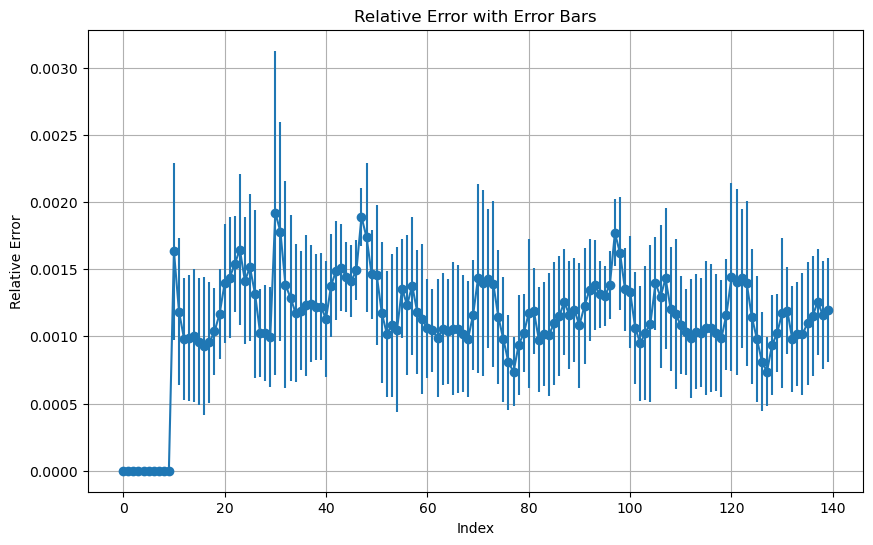

In [22]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(steps * predict_num), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Index')
plt.ylabel('Relative Error')
plt.title('Relative Error with Error Bars')
plt.grid(True)
plt.show()

In [23]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

In [24]:
np.mean(domain_relative_error)

0.014638759564343615

In [48]:
np.std(domain_relative_error)

0.0029805152218923383

In [25]:
x_dataset[0].shape

(141, 6957)

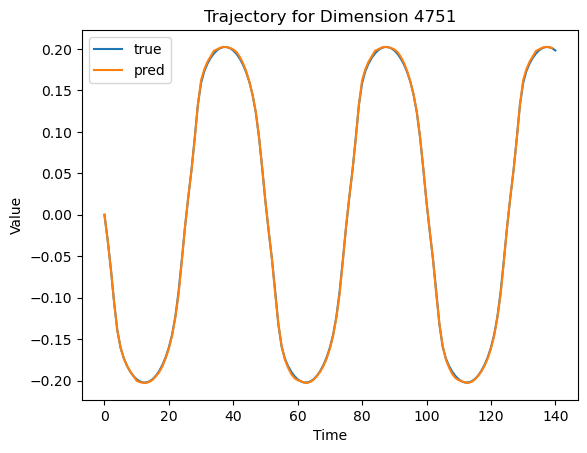

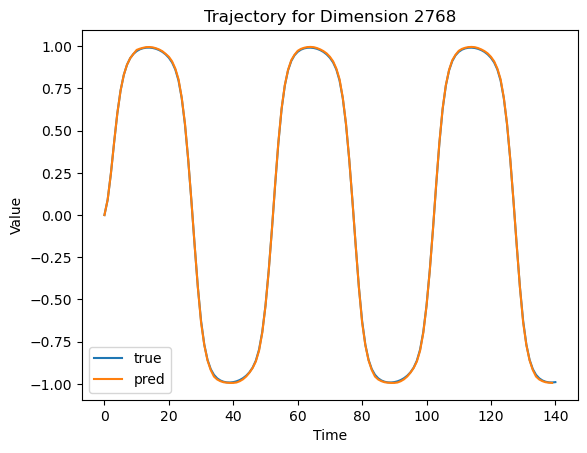

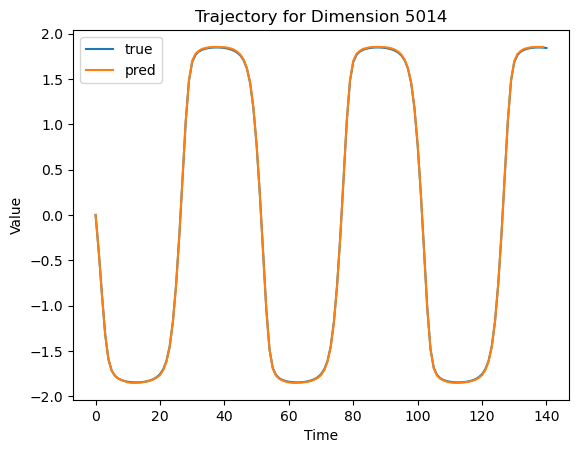

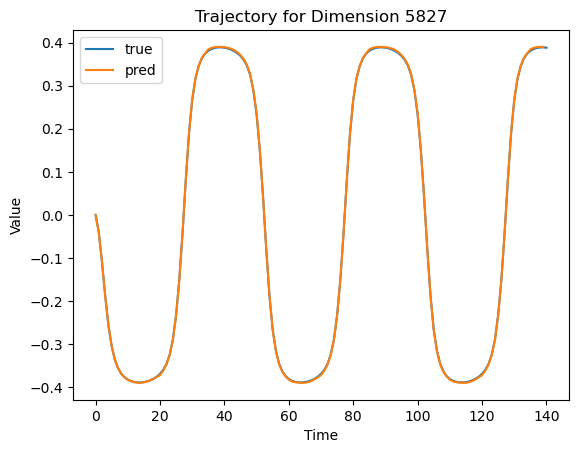

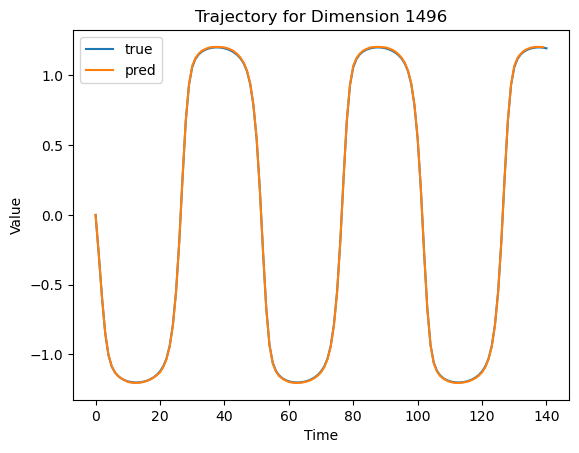

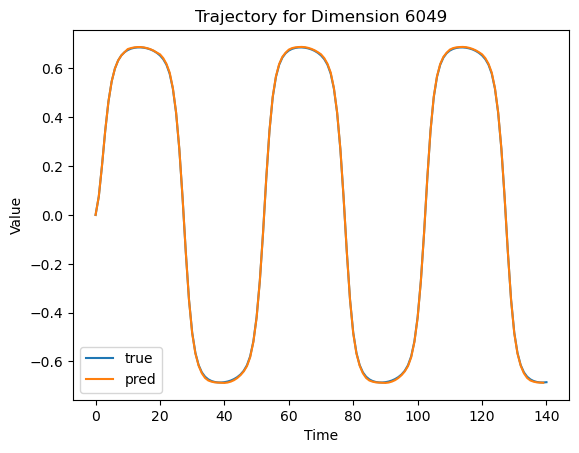

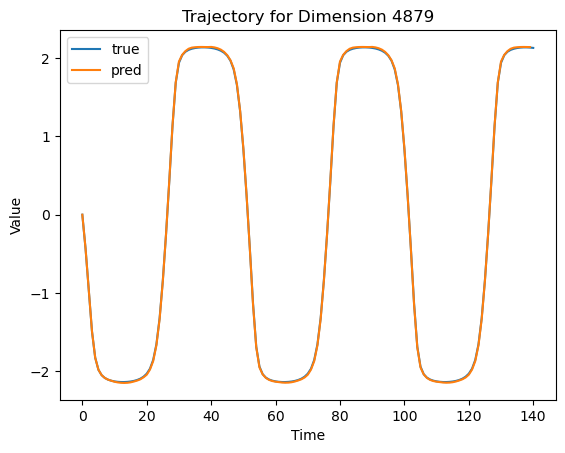

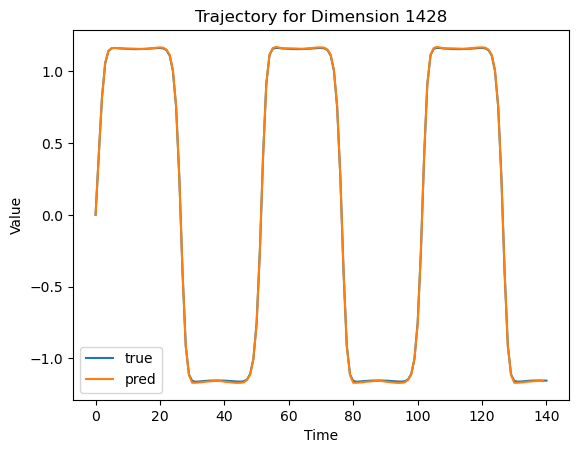

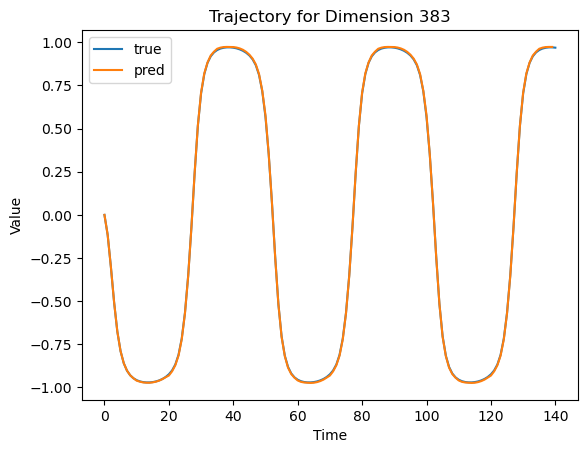

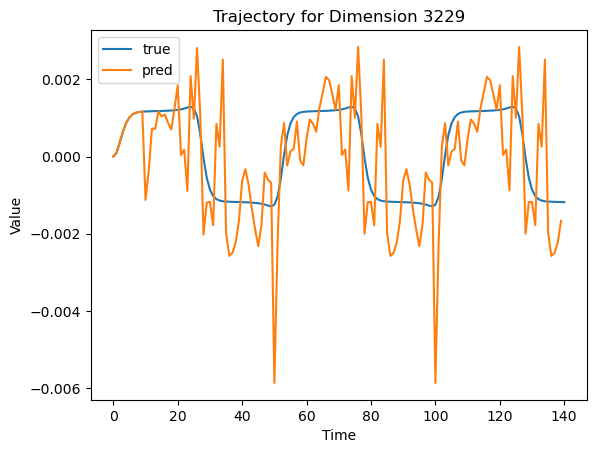

In [53]:
import numpy as np
import matplotlib.pyplot as plt

n_dimensions = x_dataset[1].shape[1]
selected_dimensions = np.random.choice(n_dimensions, 10, replace=False)
selected_dimensions[-1] = 3229
# selected_dimensions = range(10)

for i in selected_dimensions:
    plt.figure()
    y_true = x_dataset[1]
    y_pred = y_data_pred_50traj_10predict[1]
    plt.plot(y_true[:, i], label = 'true')
    plt.plot(y_pred[:, i], label = 'pred')
    plt.title(f'Trajectory for Dimension {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [27]:
errors = [y_data_pred_50traj_10predict[i] - x_dataset[i][:(steps * predict_num), :] for i in range(len(y_data_pred_50traj_10predict))]

ratios_all = np.zeros((len(errors), 6957))

for i in range(len(errors)):
    reference = x_dataset[i][:(steps * predict_num), :]
    error = errors[i]
    reference_norms = np.linalg.norm(reference, axis=0)
    error_norms = np.linalg.norm(error, axis=0)
    # print(error_norms)
    ratios_all[i] = error_norms / reference_norms

# 计算平均比值和标准差
mean_ratios = np.mean(ratios_all, axis=0)
std_ratios = np.std(ratios_all, axis=0)

mean_ratios, std_ratios

(array([0.0046002 , 0.00460054, 0.00460439, ..., 0.00690544, 0.00677944,
        0.00623659]),
 array([0.0008241 , 0.00082408, 0.00082576, ..., 0.00180852, 0.00180158,
        0.00166439]))

In [28]:
ratios_all[0]

array([0.00600463, 0.0060055 , 0.00602057, ..., 0.01156408, 0.01157977,
       0.01075823])

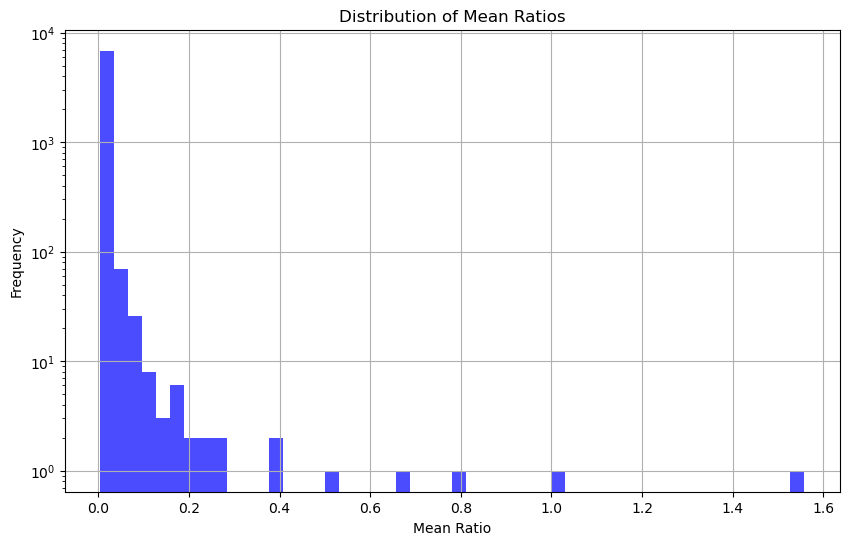

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(mean_ratios, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Mean Ratios')
plt.xlabel('Mean Ratio')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()

In [30]:
max(mean_ratios)

1.5583138940569652

In [60]:
mean_value = np.mean(mean_ratios)
print(mean_value)
count_above_mean = np.sum(mean_ratios > 0.05)
count_above_mean

0.008336945360181749


81

In [66]:
indexes_large_error = np.where(mean_ratios > 0.1)
indexes_large_error_0 = np.where(ratios_all[0] > 0.1)
indexes_large_error, indexes_large_error_0

((array([2640, 2839, 3211, 3212, 3229, 3230, 3296, 3297, 3302, 3412, 4163,
         4164, 4209, 4544, 4545, 4573, 4574, 4784, 4904, 4905, 5554, 5555,
         5721, 5902, 5915, 5916, 6038, 6536, 6809]),),
 (array([ 604, 1154, 2664, 2839, 3030, 3167, 3211, 3229, 3296, 3302, 3412,
         3455, 3746, 4163, 4209, 4250, 4544, 4573, 4783, 4790, 4904, 5016,
         5036, 5089, 5095, 5340, 5357, 5490, 5552, 5554, 5599, 5721, 5724,
         5902, 5915, 6037, 6082, 6536, 6616, 6631, 6779, 6804, 6809]),))

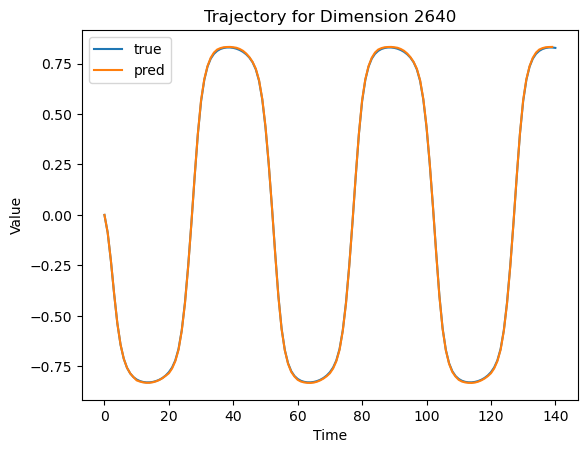

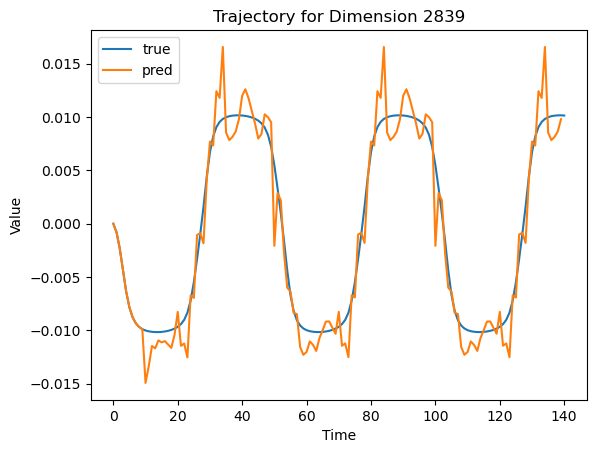

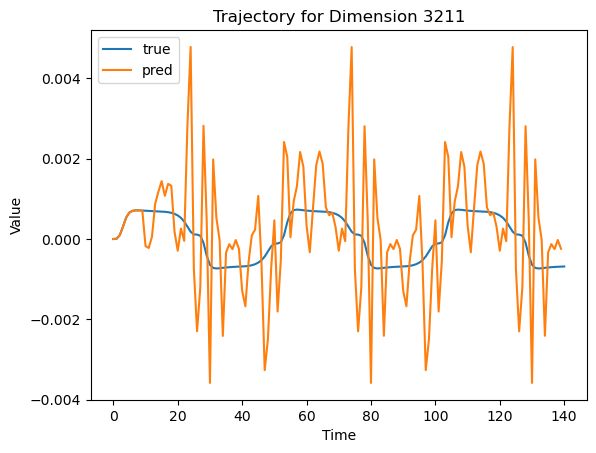

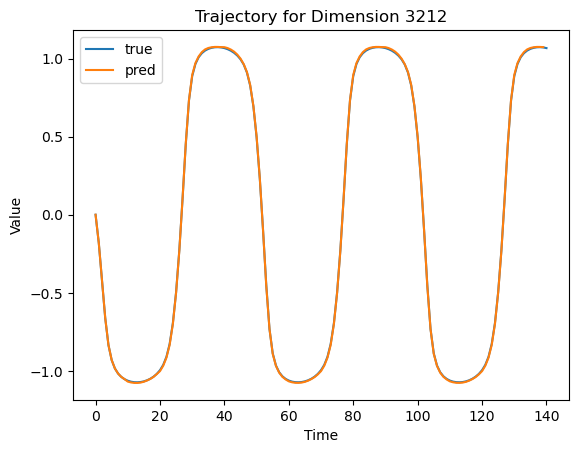

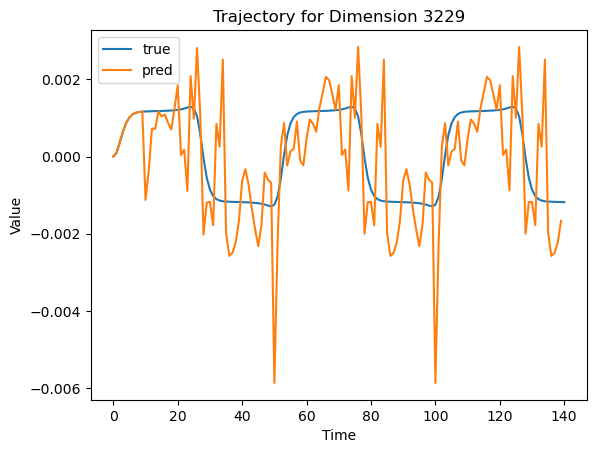

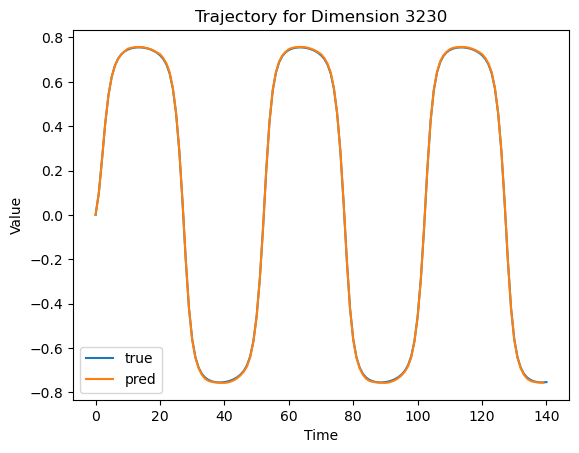

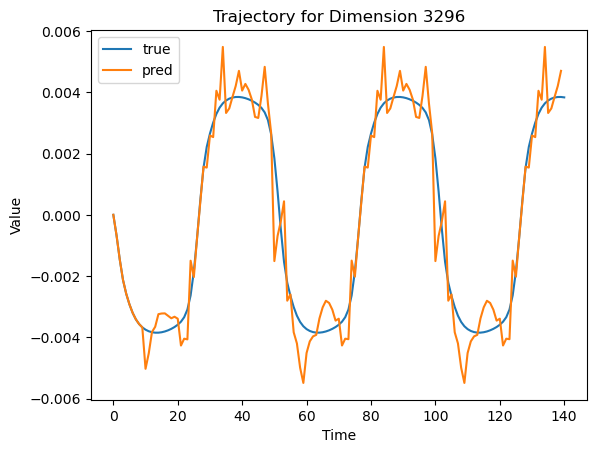

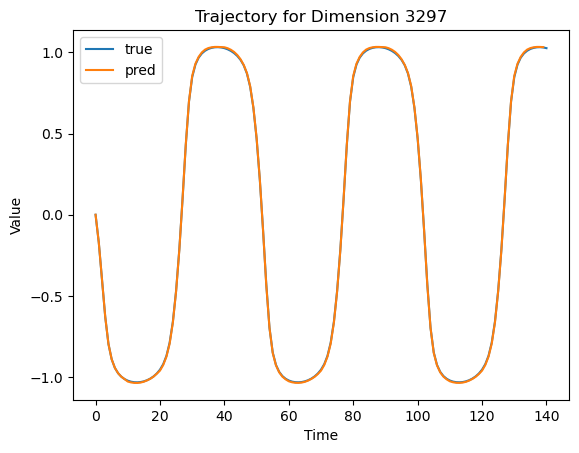

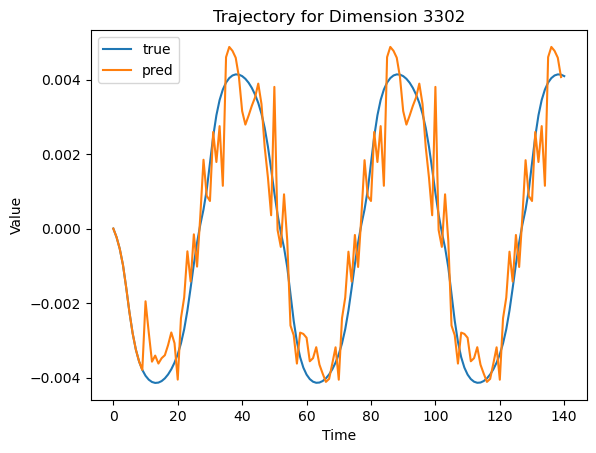

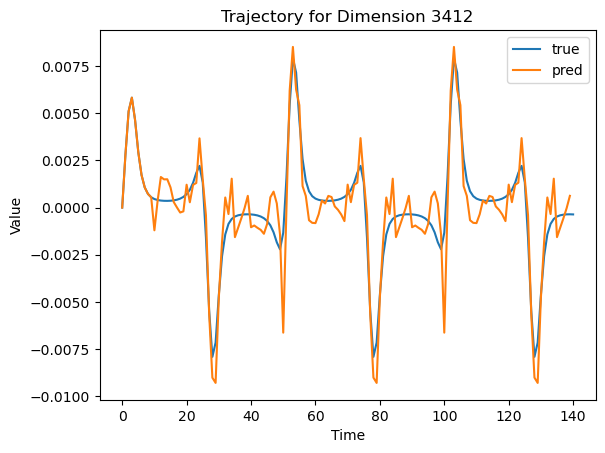

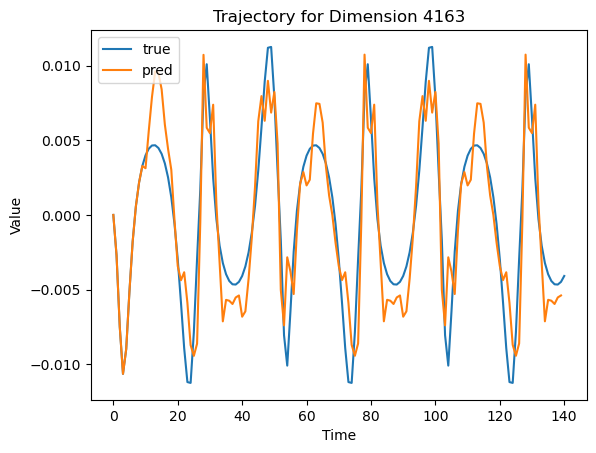

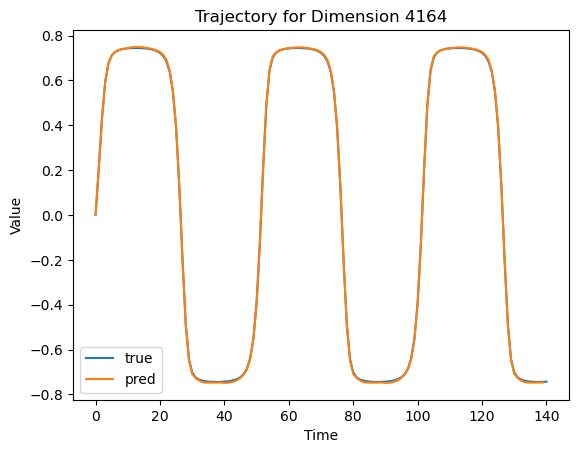

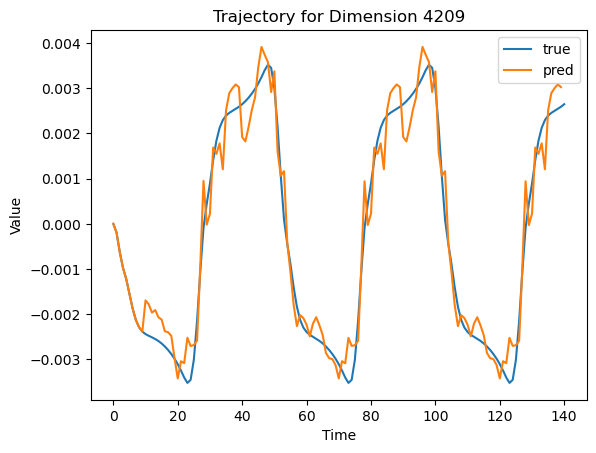

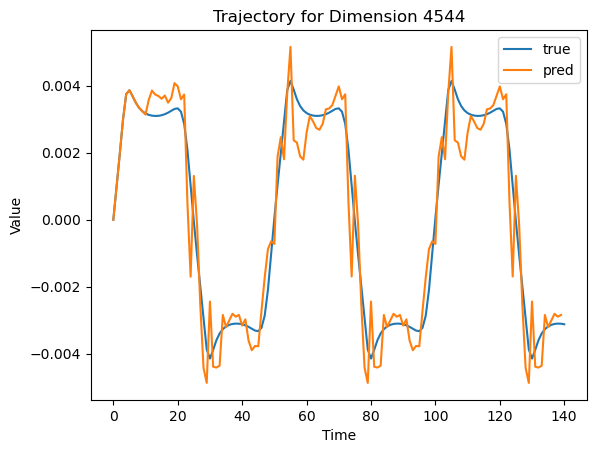

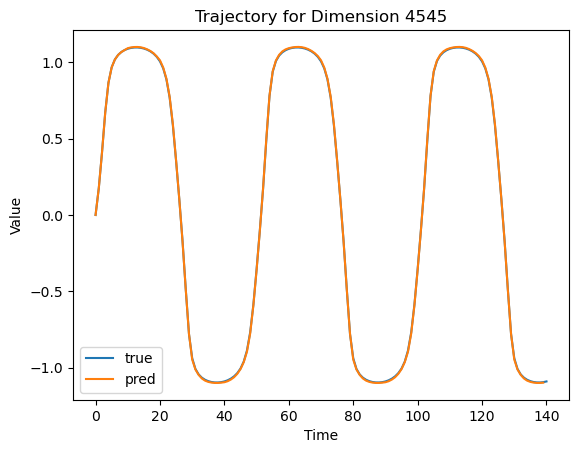

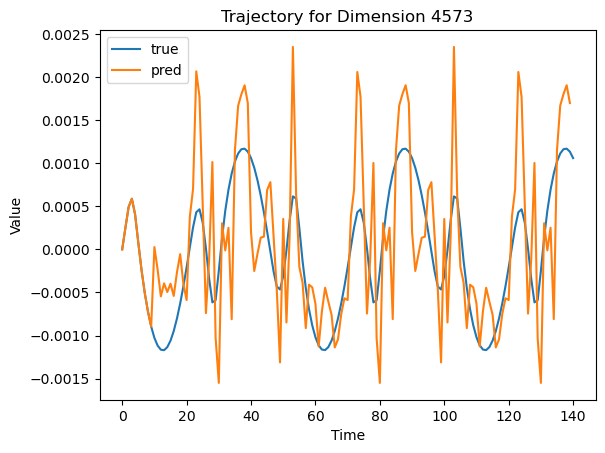

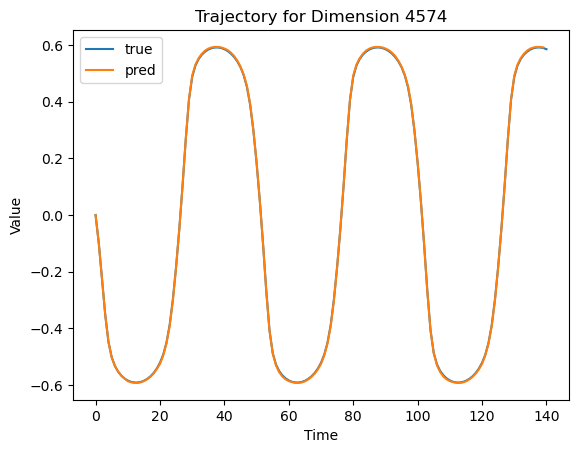

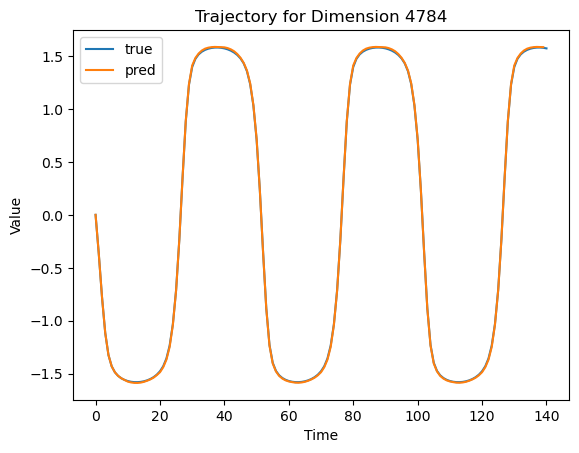

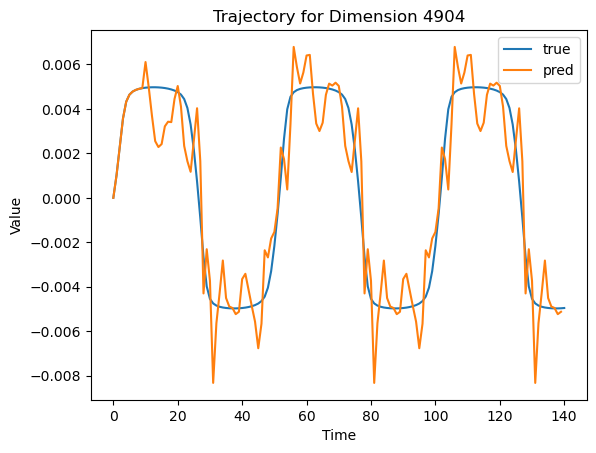

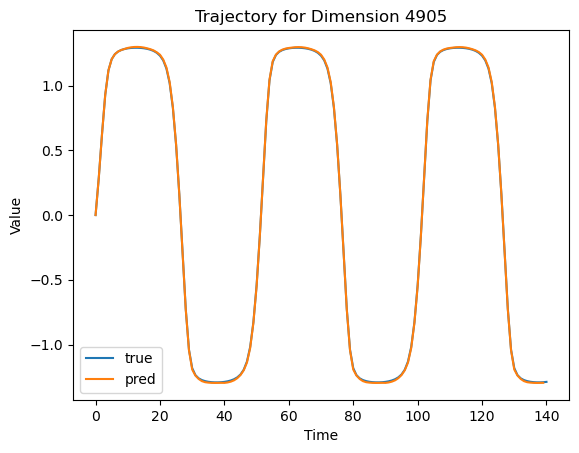

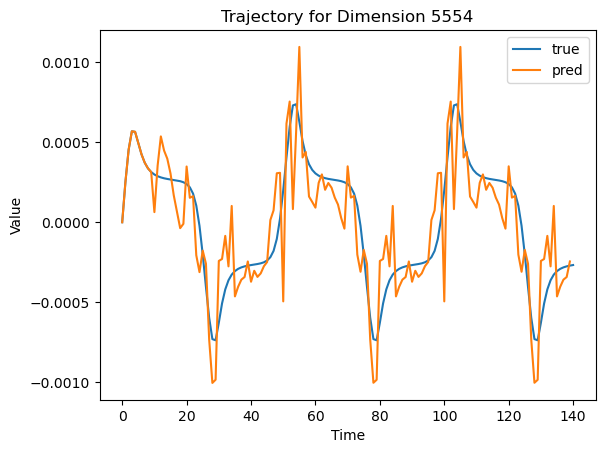

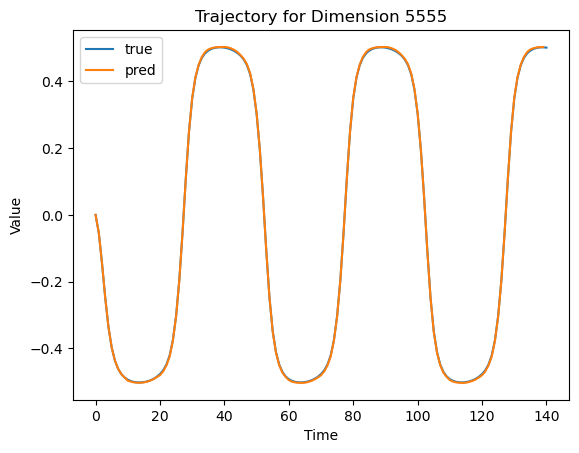

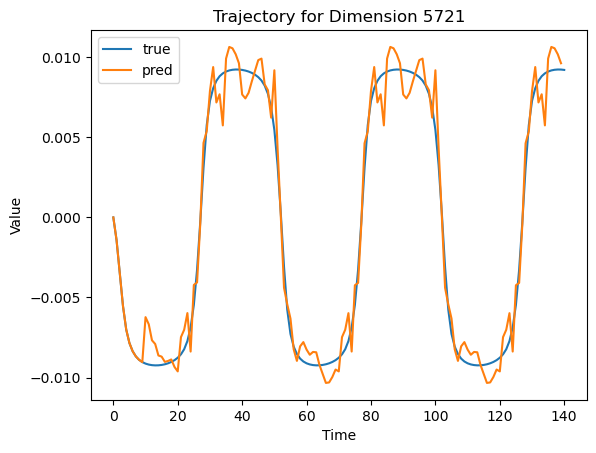

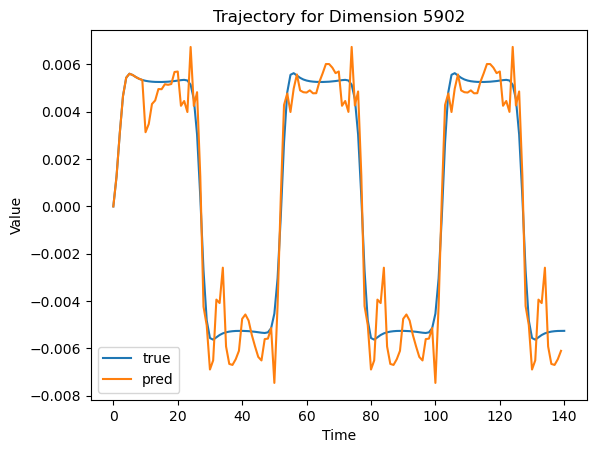

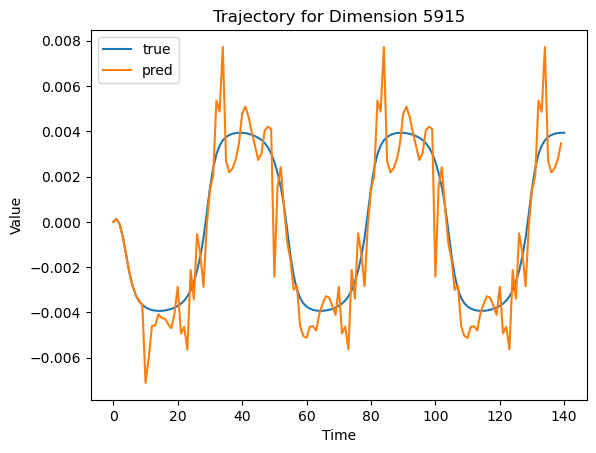

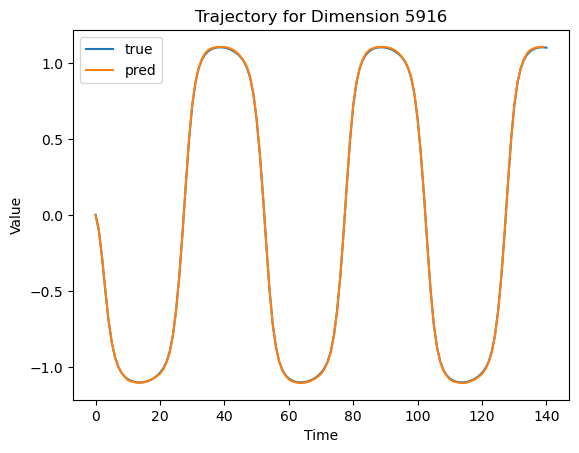

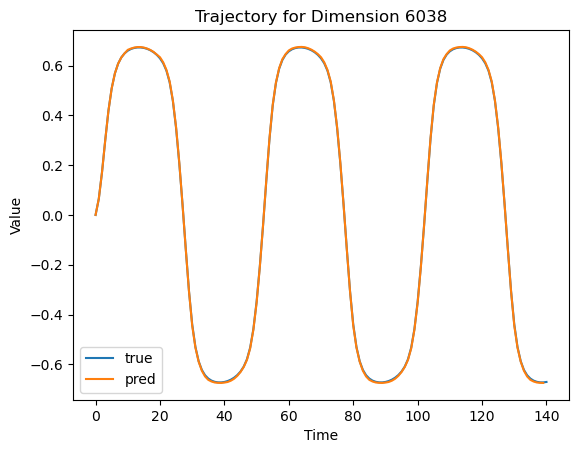

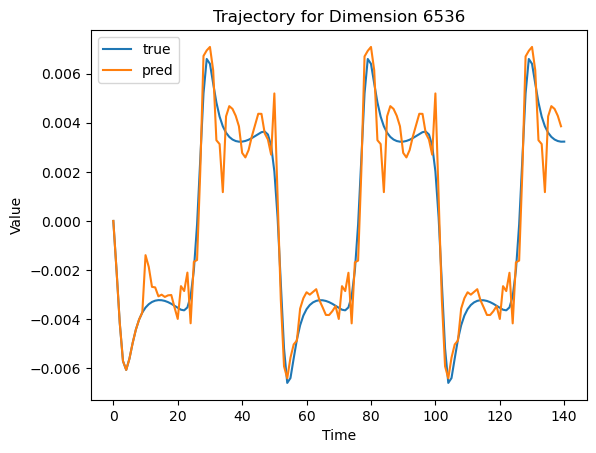

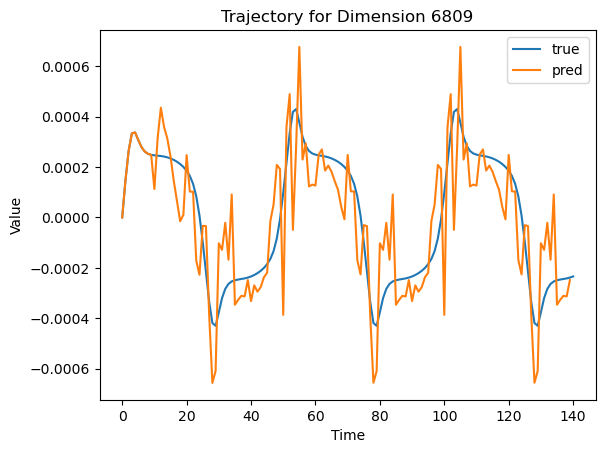

In [64]:
import numpy as np
import matplotlib.pyplot as plt

n_dimensions = x_dataset[1].shape[1]
# selected_dimensions = np.random.choice(n_dimensions, 10, replace=False)
# selected_dimensions[-1] = 3229
selected_dimensions = indexes_large_error[0]

for i in selected_dimensions:
    plt.figure()
    y_true = x_dataset[1]
    y_pred = y_data_pred_50traj_10predict[1]
    plt.plot(y_true[:, i], label = 'true')
    plt.plot(y_pred[:, i], label = 'pred')
    plt.title(f'Trajectory for Dimension {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()